# 🧠⚛️ Federated Quantum Machine Learning for Fraud Detection 🔍💳

Federated Quantum Machine Learning (FQML) combines the privacy-preserving benefits of **federated learning** with the computational power of **quantum computing**. In fraud detection, where sensitive user data is distributed across multiple institutions (e.g., banks 🏦), FQML enables **collaborative learning** without centralizing data—reducing privacy risks 🔐. Quantum models can potentially **detect complex fraud patterns** faster and more accurately than classical methods, especially in high-dimensional or noisy datasets 🚀. This makes FQML a promising tool for **real-time, secure, and scalable** fraud detection systems. 💡

- ### 🤝📊 What is Federated Machine Learning?

Federated Machine Learning (FML) is a decentralized approach to training machine learning models where **data stays on local devices** (like smartphones 📱 or bank servers 🏦) and only **model updates** are shared with a central server. This means sensitive data **never leaves its source**, enhancing privacy and compliance with regulations like GDPR 🔐. FML enables **collaborative learning** across multiple participants without exposing raw data, making it ideal for applications in healthcare 🏥, finance 💳, and more.


In [52]:
# Import necessary libraries

# Standard libraries
import os  # Interface with the operating system
import numpy as np  # Numerical operations on arrays and matrices
import pandas as pd  # Data manipulation and analysis in tabular format

# Machine learning and preprocessing libraries
from sklearn.metrics import confusion_matrix  # To compute the confusion matrix
from sklearn.preprocessing import StandardScaler  # To standardize features
from sklearn.model_selection import train_test_split  # To split data into training and testing sets

# Library for handling imbalanced datasets using oversampling
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

# Cryptography libraries
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes  # Symmetric encryption components
from cryptography.hazmat.backends import default_backend  # Backend for cryptographic operations
from cryptography.hazmat.primitives import padding  # Padding schemes for block ciphers
import struct  # For converting between C-style and Python data formats

# Quantum computing library
import pennylane as qml  # Framework for building quantum machine learning models

# Deep learning with Keras
from keras.models import Sequential  # Sequential model for neural networks
from keras.layers import Dense  # Fully connected layer
from keras.optimizers import Adam  # Adam optimization algorithm

# Duplicate import (can be removed with no effect)
from sklearn.preprocessing import StandardScaler  # Duplicate of the earlier import

# Web3 and blockchain interaction
from web3 import Web3  # Interface for Ethereum-compatible blockchains
import json  # For working with JSON data

# Homomorphic encryption library
import tenseal as ts  # Library for secure, privacy-preserving machine learning

# Cryptographic hash function
from hashlib import sha256  # SHA-256 for generating secure hashes

# Random number generation
import random  # For generating random numbers and selections

# Suppress TensorFlow logging for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Suppress TensorFlow deprecation warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Suppress all warning messages
import warnings
warnings.filterwarnings("ignore")

# Data visualization library
import matplotlib.pyplot as plt  # For creating plots and visualizations


In [53]:
ITERATIONS = 3  # Number of global training iterations
NUM_CLIENTS = 10  # Total number of participating clients/nodes in the federated system
PRIME = 104729  # A large prime number used as the modulus for Shamir's Secret Sharing scheme
THRESHOLD = 3  # Minimum number of shares required to reconstruct the secret (threshold in Shamir's scheme)

## 🔐 Quantum-Resistant Federated Learning: Weight Protection and Integrity

This code snippet demonstrates key components of a **privacy-preserving federated learning system** using a mix of **classical cryptographic** and **quantum-resistant** techniques:

- 🧩 **Shamir’s Secret Sharing**: The `shamir_split` function securely divides a secret (like a model weight) into multiple parts (shares), so that only a subset of them (threshold `k`) is required to reconstruct the original secret. This helps distribute trust and improve fault tolerance.
  
- 🔒 **CKKS Homomorphic Encryption**: The `encrypt_weights` function encrypts neural network weights using the **CKKS** scheme, allowing computations directly on encrypted data—ideal for secure federated learning across untrusted nodes.

- 🛡️ **Quantum-Resistant Hashing**: The `qhash` function ensures data integrity using **SHA-256**, a hash function considered resistant to quantum attacks under Grover’s algorithm.

In [55]:
# Shamir’s Secret Sharing: Splitting weights
def shamir_split(secret, n, k, prime=PRIME):
    # Generate k random coefficients for the polynomial, with the secret as the constant term
    coeffs = [secret] + [random.randint(0, prime - 1) for _ in range(k - 1)]
    # Generate n shares using the polynomial and modulo arithmetic
    shares = [
        (i, sum(c * (i ** j) for j, c in enumerate(coeffs)) % prime)
        for i in range(1, n + 1)
    ]
    return shares  # Return list of (x, y) pairs representing the secret shares

# Encrypt weights with CKKS
def encrypt_weights(weights, context):
    encrypted_weights = []
    for weight in weights:
        flat_weights = weight.flatten().tolist()  # Flatten weight array to 1D list
        encrypted_vector = ts.ckks_vector(context, flat_weights)  # Encrypt using CKKS scheme
        encrypted_weights.append(encrypted_vector)
    return encrypted_weights  # Return list of encrypted weight vectors

# Define Qhash function
def qhash(data):
    #Generate a quantum-resistant hash (SHA-256) for the given data
    return sha256(data.encode()).hexdigest()  # Return hexadecimal digest of the SHA-256 hash

## 🧮 Aggregation Functions
This code implements **adaptive and privacy-preserving aggregation techniques** for use in federated or quantum-aware machine learning systems:

- 🔧 `generate_adaptive_factors` creates random scaling factors for each client, allowing their contributions to be **weighted** based on trust, data volume, or other metrics.
- ➕ `weighted_average_ckks_nested` performs a **CKKS-encrypted weighted average** across clients' neural network layers, maintaining privacy by operating directly on encrypted values.
- ⚖️ `median_aggregator_qnn_parameters` uses a **weighted median** to robustly aggregate quantum neural network (QNN) parameters, offering **outlier resistance** and enhanced fault tolerance.
- 🛡️ `qhash` and `str_to_bytes32` ensure **quantum-resistant integrity** and compatibility with blockchain systems via SHA-256 hashing and `bytes32` encoding.


In [57]:
# Generate adaptive factors for each client
def generate_adaptive_factors(num_clients, lower=0.5, upper=1.5):
    """Generate random adaptive scaling factors for each client within a specified range.
    These factors are typically used to weight each client's contribution during aggregation, 
    possibly based on their data size, quality, or trustworthiness.
    """
    factors = [random.uniform(lower, upper) for _ in range(num_clients)]
    return factors


# Perform weighted average aggregation
def weighted_average_ckks_nested(encrypted_weights, factors):
    """Perform weighted average aggregation on nested CKKS-encrypted weights.
    Each client's encrypted model weights are weighted by a predefined factor,
    then averaged across clients using CKKS homomorphic operations (no decryption).
    Args:
        encrypted_weights: List of lists of CKKS-encrypted weights (by client, then layer).
        factors: List of adaptive factors, one per client.
    Returns:
        A list of aggregated encrypted weights, layer by layer.
    """
    total_factor = sum(factors)
    aggregated_weights = []

    for layer_idx in range(len(encrypted_weights[0])):
        # Start with a copy of the first client’s encrypted layer
        aggregated_layer = encrypted_weights[0][layer_idx].copy()

        # Add weighted contributions from remaining clients
        for i, client_weights in enumerate(encrypted_weights[1:], start=1):
            aggregated_layer += client_weights[layer_idx] * (factors[i] / total_factor)

        aggregated_weights.append(aggregated_layer)  # Store aggregated layer

    # Log the decrypted size of each aggregated layer (for debug or analysis)
    for idx, layer in enumerate(aggregated_weights):
        print(f"Layer {idx}: Aggregated weights size = {len(layer.decrypt())}")

    return aggregated_weights


# Perform weighted median aggregation for quantum neural network parameters
def median_aggregator_qnn_parameters(encrypted_params, factors):
    """
    Perform weighted median aggregation on encrypted QNN (Quantum Neural Network) parameters.
    Instead of averaging, this uses the weighted median to offer robustness against outliers or malicious clients.
    Assumes parameters are encrypted and homomorphically decryptable (e.g., CKKS).
    Args:
        encrypted_params: List of encrypted parameter sets (one per client), each a list of layers.
        factors: List of adaptive weighting factors per client.
    Returns:
        A list of aggregated parameters (optionally re-encrypted after median computation).
    """


    total_factor = sum(factors)
    num_layers = len(encrypted_params[0])  # Assumes consistent model layer structure
    aggregated_params = []

    for layer_idx in range(num_layers):
        # Collect current layer from all clients
        layer_params = [client[layer_idx] for client in encrypted_params]
        # Decrypt each client's parameter vector for median calculation
        layer_stack = np.array([param.decrypt() for param in layer_params])
        weights = np.array(factors) / total_factor  # Normalize weights to sum to 1
        median_layer = np.zeros_like(layer_stack[0])  # Placeholder for median values

        # For each parameter position in the layer
        for param_idx in range(layer_stack.shape[1]):  # Assuming 1D arrays per layer
            param_values = layer_stack[:, param_idx]
            # Sort values and their associated weights
            sorted_indices = np.argsort(param_values)
            sorted_values = param_values[sorted_indices]
            sorted_weights = weights[sorted_indices]
            # Compute cumulative weights
            cumulative_weights = np.cumsum(sorted_weights)
            # Identify the smallest index where cumulative weight exceeds 0.5
            median_index = np.searchsorted(cumulative_weights, 0.5)
            median_layer[param_idx] = sorted_values[median_index]

        # Append median result (could be re-encrypted here)
        aggregated_params.append(median_layer)
        print(f"Layer {layer_idx}: Aggregated parameters size = {len(median_layer)}")

    return aggregated_params


# Define Qhash function
def qhash(data):
    """Generate a quantum-resistant hash (SHA-256) for the given data.
    Useful for ensuring data integrity or generating unique identifiers in secure systems.
    Args:
        data: Input string to be hashed.
    Returns:
        Hexadecimal SHA-256 hash of the input string.
    """
    return sha256(data.encode()).hexdigest()


# Convert the aggregated Qhash to bytes32
def str_to_bytes32(input_str):
    """Convert a hexadecimal string to a fixed-size 32-byte representation (bytes32).
    Often used for compatibility with blockchain systems like Ethereum, 
    where bytes32 is a common data type.
    Args:
        input_str: Hex string (e.g., from SHA-256 hash).
    Returns:
        A bytes object of length 32.
    """
    return bytes.fromhex(input_str)


## 🧷 Serialization and Encryption

This section focuses on **model weight serialization and encryption**, essential for securely transmitting neural network parameters in federated or quantum-secure systems:

- 🧪 `serialize_model_weights` extracts and flattens all trainable weights and biases from a Keras model, then serializes each float into a compact 4-byte binary format—ideal for efficient and consistent transport or encryption.
- 🔐 `encrypt_with_aes` secures the serialized weights using **AES encryption** in ECB mode with **PKCS7 padding**, transforming sensitive model data into unreadable ciphertext blocks.
- ⚛️ `simulate_qkd_resources` mimics **Quantum Key Distribution (QKD)** by generating secure random AES keys for each node, emulating how encryption keys might be distributed via quantum channels in a real QKD network.

In [59]:
def serialize_model_weights(model):
    """Flatten weights and biases for all layers into a single list of bytes.
    This function extracts all trainable parameters (weights and biases) from a Keras model,
    flattens them into a 1D list, and then serializes each float to 4-byte binary format using `struct.pack`.
    Args:
        model: A Keras model object.
    Returns:
        A list of bytes, where each float weight/bias is serialized into 4 bytes.
    """
    serialized_weights = []

    for layer in model.layers:
        if hasattr(layer, "get_weights"):  # Check if the layer has trainable parameters
            weights = layer.get_weights()

            if len(weights) == 2:  # Layer has both weights and biases
                serialized_weights.extend(weights[0].flatten())  # Flatten and collect weights
                serialized_weights.extend(weights[1].flatten())  # Flatten and collect biases
            elif len(weights) == 1:  # Only weights, no biases
                serialized_weights.extend(weights[0].flatten())
            else:
                print(f"Layer {layer.name} has no trainable weights or biases.")

    # Convert all floats to 4-byte big-endian binary format
    return [struct.pack("!f", w) for w in serialized_weights]


def encrypt_with_aes(plaintext_weights, key):
    """Encrypt a list of serialized model weights using AES encryption.
    Uses AES in ECB (Electronic Code Book) mode with PKCS7 padding for block alignment.
    Args:
        plaintext_weights: List of byte-serialized float weights (e.g., output from `serialize_model_weights`).
        key: AES key (must be 16, 24, or 32 bytes long for AES-128, AES-192, or AES-256).
    Returns:
        A list of encrypted 16-byte blocks.
    """
    if len(key) not in {16, 24, 32}:
        raise ValueError("Invalid AES key length. Must be 16, 24, or 32 bytes.")

    # Set up AES cipher in ECB mode
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()

    # Join all byte-packed weights into a single plaintext byte string
    plaintext_bytes = b"".join(plaintext_weights)

    # Apply PKCS7 padding to align data with AES block size (16 bytes = 128 bits)
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(plaintext_bytes) + padder.finalize()

    # Encrypt each 16-byte block
    encrypted_weights = []
    for i in range(0, len(padded_data), 16):
        block = padded_data[i:i + 16]
        encrypted_weights.append(encryptor.update(block))

    return encrypted_weights


def simulate_qkd_resources(num_nodes):
    """Simulate Quantum Key Distribution (QKD) by generating AES keys for each node.
    This is a mock simulation that mimics QKD by generating secure random keys.
    In a real QKD system, keys would be exchanged via quantum channels.
    Args:
        num_nodes: Total number of nodes or clients in the network.
    Returns:
        A dictionary mapping each node ID to its QKD-generated key (random 16 bytes).
    """
    return {
        node_id: {"key": os.urandom(16)}  # Generate a random 128-bit key per node
        for node_id in range(num_nodes)
    }


## 📤 Deserialization and Decryption of Model Weights

This section focuses on **reconstructing neural network weights** from their encrypted and serialized forms, ensuring model integrity and usability after secure transmission:

- 🔓 `decrypt_with_aes` takes a list of AES-encrypted 16-byte blocks (from `encrypt_with_aes`), decrypts them using the provided key, removes **PKCS7 padding**, and converts the raw bytes back into float values. This restores the original flattened representation of model weights while ensuring **confidentiality** during transfer.
  
- 🧩 `deserialize_model_weights` reverses the serialization process by reshaping the flat list of floats into the **original tensor structures** expected by each layer in a Keras model. It dynamically adapts to the model’s architecture, rebuilding both weights and biases where applicable.

In [61]:
def decrypt_with_aes(encrypted_model, key):
    """Decrypt the encrypted global model using the AES key.
    This function takes an AES-encrypted list of 16-byte blocks and decrypts it using
    the provided AES key. It also removes padding and converts the raw bytes back to float values.
    Args:
        encrypted_model: List of 16-byte AES-encrypted blocks.
        key: AES key used for decryption (must be 16, 24, or 32 bytes).
    Returns:
        A list of decrypted float values representing the model weights.
    """
    if len(key) not in {16, 24, 32}:
        raise ValueError("Invalid AES key length. Must be 16, 24, or 32 bytes.")

    # Set up AES cipher in ECB mode
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()

    # Decrypt each encrypted block and concatenate the results
    decrypted_bytes = b"".join([decryptor.update(block) for block in encrypted_model])

    # Remove PKCS7 padding applied during encryption
    unpadder = padding.PKCS7(128).unpadder()
    plaintext_bytes = unpadder.update(decrypted_bytes) + unpadder.finalize()

    # Deserialize byte chunks (4 bytes each) back to float values
    decrypted_weights = [
        struct.unpack("!f", plaintext_bytes[i:i + 4])[0]
        for i in range(0, len(plaintext_bytes), 4)
    ]

    return decrypted_weights


def deserialize_model_weights(serialized_weights, model):
    """Reshape serialized weights and biases back into their original shapes.
    This reverses the flattening/serialization process. It reshapes the list of
    floats into the original tensor shapes expected by each layer of the model.
    Args:
        serialized_weights: Flat list of floats representing model weights/biases.
        model: A Keras model whose structure defines the target shapes.
    Returns:
        A list of tuples for each layer: (weights, biases) or (weights, None) if no biases.
    """
    deserialized_weights = []
    start = 0  # Pointer to keep track of position in the serialized weights list

    for layer in model.layers:
        if hasattr(layer, "get_weights"):
            weights = layer.get_weights()

            if len(weights) == 2:  # Both weights and biases exist
                weight_shape = weights[0].shape
                bias_shape = weights[1].shape

                weight_count = np.prod(weight_shape)  # Total number of weight elements
                bias_count = np.prod(bias_shape)      # Total number of bias elements

                # Slice and reshape weights
                weights_array = np.array(
                    serialized_weights[start:start + weight_count]
                ).reshape(weight_shape)

                # Slice and reshape biases
                biases_array = np.array(
                    serialized_weights[start + weight_count:start + weight_count + bias_count]
                ).reshape(bias_shape)

                deserialized_weights.append((weights_array, biases_array))
                start += weight_count + bias_count

            elif len(weights) == 1:  # Only weights (no biases)
                weight_shape = weights[0].shape
                weight_count = np.prod(weight_shape)

                weights_array = np.array(
                    serialized_weights[start:start + weight_count]
                ).reshape(weight_shape)

                deserialized_weights.append((weights_array, None))
                start += weight_count

    return deserialized_weights


## 🔄 Update Model Functions: Distributing Global Weights to Clients

This function ensures that each client in a federated learning setup receives the **latest global model update**:

- 🔁 `update_client_models` iterates over a list of local Keras models and updates their parameters with **decrypted and deserialized global weights**. These weights are personalized and matched by client ID.
- 🧠 It uses the `deserialize_model_weights` function to reshape flattened float lists back into structured tensors (weights and biases), and assigns them layer-by-layer.
- 📦 This is a critical step in the **federated learning loop**, allowing each client to synchronize with the latest global knowledge before continuing local training.

In [63]:
def update_client_models(client_models, decrypted_global_models):
    """Update client models with the decrypted global weights.
    
    This function assigns the newly decrypted and deserialized global model weights 
    back to each individual client's model. It ensures that each client receives 
    the correct version of the global model tailored for them.

    Args:
        client_models: List of Keras model instances, one per client.
        decrypted_global_models: Dictionary mapping client node IDs to lists of 
                                 decrypted and flattened weights (per-client global models).
    """
    for node_id, model in enumerate(client_models):
        # Only update if a decrypted model is available for this client
        if node_id in decrypted_global_models:
            # Convert the flat float list back into structured weights and biases
            deserialized_weights = deserialize_model_weights(decrypted_global_models[node_id], model)

            # Apply deserialized weights to each layer of the model
            for layer, (weights, biases) in zip(model.layers, deserialized_weights):
                if biases is not None:
                    layer.set_weights([weights, biases])  # Assign both weights and biases
                else:
                    layer.set_weights([weights])  # Assign only weights for layers without biases

    print("Client models updated with new global weights.")

## 🧪 Evaluation Function: Measuring Model Accuracy

This function provides a straightforward way to **evaluate the performance** of a global model on unseen data:

- ✅ `evaluate_model` takes a trained Keras model along with test features and labels, then predicts class probabilities using `.predict()`.
- 🔍 It converts these probabilities to class labels using `argmax`, compares them to the true labels, and computes the **accuracy as a percentage**.
- 📊 This is a key step in assessing the effectiveness of a federated or centralized training process, helping validate the **generalization capability** of the global model.

In [65]:
# Function to evaluate model on the test set
def evaluate_model(global_model, X_test, y_test):
    """
    Evaluate the global model's accuracy on the test dataset.
    Args:
        global_model: Trained Keras model to be evaluated.
        X_test: Input features for the test set.
        y_test: True labels for the test set (assumed to be class indices).
    Returns:
        Accuracy of the model on the test set, as a percentage.
    """
    y_pred = global_model.predict(X_test)  # Get model predictions (probabilities for each class)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions
    accuracy = np.mean(y_pred_classes == y_test) * 100  # Compute accuracy percentage
    return accuracy


In [66]:
# Load dataset
df = pd.read_csv("dataset/fraud_detection_bank_dataset.csv")
scaler = StandardScaler()

## 🧹 Data Preprocessing

In [68]:
# Initialize the scaler
scaler = StandardScaler()  # Standardizes features by removing the mean and scaling to unit variance

# Preprocess dataset
X = scaler.fit_transform(df.drop(columns=["targets"]))  # Drop target column and scale feature values
y = df["targets"]  # Extract target labels (e.g., fraud/non-fraud)

# Train-test split (for global evaluation or baseline)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Split dataset among clients with a specified fraud-to-non-fraud ratio
def split_data_with_ratio(df, num_clients, target_col='targets', ratio=2.763):
    """
    Splits the dataset into subsets for each client, maintaining a specified 
    ratio of non-fraud to fraud samples to simulate non-IID data.
    Args:
        df: Full dataset with features and target.
        num_clients: Number of client subsets to create.
        target_col: Column name representing the target variable.
        ratio: Desired ratio of non-fraud to fraud cases per client.
    Returns:
        A list of DataFrames, each assigned to a client.
    """
    fraud_indices = df[df[target_col] == 1].index  # Indices of fraud cases
    non_fraud_indices = df[df[target_col] == 0].index  # Indices of non-fraud cases

    # Calculate how many fraud and non-fraud samples each client should receive
    fraud_per_client = len(fraud_indices) // num_clients
    non_fraud_per_client = int(fraud_per_client * ratio)

    client_dfs = []  # List to store each client's DataFrame
    start_fraud = 0
    start_non_fraud = 0

    for _ in range(num_clients):
        # Determine the end index for the current client's slice
        end_fraud = min(start_fraud + fraud_per_client, len(fraud_indices))
        end_non_fraud = min(start_non_fraud + non_fraud_per_client, len(non_fraud_indices))

        # Combine fraud and non-fraud indices for this client
        client_indices = list(fraud_indices[start_fraud:end_fraud]) + list(non_fraud_indices[start_non_fraud:end_non_fraud])
        client_df = df.loc[client_indices]

        client_dfs.append(client_df)  # Add to list of client datasets
        start_fraud = end_fraud
        start_non_fraud = end_non_fraud

    return client_dfs


# Create client datasets from full dataframe
client_dfs = split_data_with_ratio(df, NUM_CLIENTS)


# Split each client dataset into training and test sets
def split_client_data(client_dfs, test_size=0.2, random_state=42):
    """
    Splits each client's dataset into train and test subsets.
    Args:
        client_dfs: List of DataFrames, one per client.
        test_size: Proportion of data to include in the test split.
        random_state: Seed for reproducibility.
    Returns:
        List of tuples: (X_train, X_test, y_train, y_test) for each client.
    """
    client_splits = []

    for client_df in client_dfs:
        # Extract features and labels
        X = scaler.fit_transform(client_df.drop(columns=["targets"]))  # Normalize features
        y = client_df["targets"]

        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Store the split for this client
        client_splits.append((X_train, X_test, y_train, y_test))

    return client_splits


# Generate train-test splits for all clients
client_splits = split_client_data(client_dfs)


In [69]:
# Calculate the ratio of 1s to 0s in the 'isFraud' column
ratio = df['targets'].sum() / (len(df['targets']) - df['targets'].sum())
print(f"Ratio of 1s to 0s: {1/ratio}")

Ratio of 1s to 0s: 2.7638837808017653


## ⚛️ Quantum Layer Architecture

In [71]:
def custom_layer_long(weights, n_qubits):
    index = 0  # Start index for weights

    # First block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1
    # First set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)
    # Second block of RY
    for i in range(n_qubits + 1):
        qml.RY(weights[index], wires=i)
        index += 1
    # Second set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)
    # Third block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1
    # Nested loop of RY
    for j in range(2):
        for i in range(n_qubits):
            qml.RY(weights[index], wires=i)
            index += 1
    # Third set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)
    # First block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1
    # Fourth set of CNOT pairs
    pairs = [(0, 2), (2, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)
    # Fourth block of RY (single qubit repeated)
    qml.RY(weights[index], wires=3)
    index += 1
    qml.RY(weights[index], wires=3)
    index += 1
    # Second block of RZ
    for i in range(n_qubits):
        qml.RZ(weights[index], wires=i)
        index += 1
    # Third block of RY
    for i in range(n_qubits):
        qml.RY(weights[index], wires=i)
        index += 1
    # Fifth set of CNOT pairs
    pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
    for pair in pairs:
        qml.CNOT(wires=pair)
    # Final block of RZ
    for i in range(n_qubits + 1):
        qml.RZ(weights[index], wires=i)
        index += 1

    return index

In [72]:
# Quantum Device and QNode
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits + 1)

@qml.qnode(dev)
def qnode_long(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits+1))
    for w in weights:
        custom_layer_long(w,n_qubits)
        
        
    outputs = [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
    return outputs

n_layers = 1
total_weights_long = 32
weight_shapes_long = {"weights": (n_layers, total_weights_long+1)}
qlayer = qml.qnn.KerasLayer(qnode_long, weight_shapes_long, output_dim=n_qubits)

## 🧠 Local Quantum Model

In [74]:
# Define the local quantum model for each node
def build_quantum_model():
    model = Sequential([
        Dense(4, activation="relu"),
        qlayer,
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [75]:
# To store accuracy results over multiple iterations
evaluation_results_global = []  # Accuracy on the combined test set
evaluation_results_local = []   # Accuracy of a specific client (Client 1)

# Initialize local models for each client (quantum models assumed)
client_models = [build_quantum_model() for _ in range(NUM_CLIENTS)]

# Begin federated training for a defined number of iterations
for iteration in range(ITERATIONS):
    print(f"\n--- Iteration {iteration + 1} ---")

    # Train each client's model on its local data
    for client_id, (X_train, X_test, y_train, y_test) in enumerate(client_splits):
        print(f"Training quantum model for Client {client_id + 1}")
        client_models[client_id].fit(X_train, y_train, batch_size=25, epochs=3, verbose=1)

    # Constants for hybrid encryption & secret sharing
    PRIME = 104729
    THRESHOLD = 3
    NUM_NODES = NUM_CLIENTS

    # Initialize CKKS homomorphic encryption context
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60, 40, 40, 60]
    )
    context.global_scale = 2 ** 40
    print("CKKS Context initialized.")

    # Secure each client's trained weights
    encrypted_shares = []
    for client_id, model in enumerate(client_models):
        print(f"Securing weights for Client {client_id + 1}")

        # Extract layer weights from Dense layers only
        weights = [layer.get_weights()[0] for layer in model.layers if isinstance(layer, Dense)]

        # Split weights using Shamir's Secret Sharing
        node_shares = [
            [shamir_split(int(value * 1e6), NUM_NODES, THRESHOLD, PRIME)
             for value in weight_matrix.flatten()]
            for weight_matrix in weights
        ]

        # Encrypt weights using CKKS
        encrypted_weights = encrypt_weights(weights, context)
        encrypted_shares.append(encrypted_weights)

        print(f"Client {client_id + 1}: Weights encrypted and secured.")

    # --- Blockchain Integration ---

    # Generate and prepare Qhashes for blockchain logging
    blockchain_batches = []
    BATCH_SIZE = 10  # Number of clients per batch

    print("Generating Qhashes and preparing batches for the blockchain...")

    for batch_start in range(0, len(encrypted_shares), BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, len(encrypted_shares))
        batch_hashes = []

        for node_id in range(batch_start, batch_end):
            serialized_shares = []

            # Serialize encrypted vectors to hex
            for encrypted_weight in encrypted_shares[node_id]:
                if isinstance(encrypted_weight, ts.CKKSVector):
                    serialized_shares.append(encrypted_weight.serialize().hex())

            # Generate SHA-256 Qhash for this client
            serialized_shares_str = str(serialized_shares)
            hash_value = qhash(serialized_shares_str)
            batch_hashes.append(hash_value)

        blockchain_batches.append({
            "batch_start": batch_start,
            "batch_end": batch_end,
            "hashes": batch_hashes
        })

    print(f"Prepared {len(blockchain_batches)} batches of Qhashes for blockchain submission.")

    # Connect to Ethereum blockchain
    web3 = Web3(Web3.HTTPProvider("http://127.0.0.1:7545"))  # Local Ganache or testnet

    # Load smart contract interface (ABI)
    with open('Blockchain/NewSecureAggregation.json') as f:
        contract_abi = json.load(f)["abi"]

    # Contract deployment address
    contract_address = "0x82c62D012b1E3D9d2FD2385711820cC51857B817"
    contract = web3.eth.contract(address=contract_address, abi=contract_abi)

    # Use first Ethereum account
    account = web3.eth.accounts[0]
    web3.eth.default_account = account

    # Submit hash batches to the blockchain
    print("Submitting Qhash batches to the blockchain...")
    for batch in blockchain_batches:
        try:
            batch_hashes_bytes = [bytes.fromhex(h) for h in batch["hashes"]]
            tx = contract.functions.submitBatch(
                batch["batch_start"], batch["batch_end"], batch_hashes_bytes
            ).transact()

            receipt = web3.eth.wait_for_transaction_receipt(tx)
            print(f"Batch {batch['batch_start']} to {batch['batch_end']} submitted. Tx Hash: {receipt.transactionHash.hex()}")

        except Exception as e:
            print(f"Error submitting batch {batch['batch_start']} to {batch['batch_end']}: {e}")

    print("All Qhash batches successfully submitted to the blockchain.")

    # Generate adaptive weights for aggregation
    adaptive_factors = generate_adaptive_factors(NUM_CLIENTS)

    # Aggregate encrypted weights across clients using weighted median
    print("Aggregating encrypted weights using CKKS and adaptive factors...")
    try:
        aggregated_encrypted_weights = median_aggregator_qnn_parameters(encrypted_shares, adaptive_factors)
        print("Encrypted weights aggregated successfully.")
    except Exception as e:
        print(f"Error during aggregation: {e}")

    # Generate Qhash for the aggregated model
    print("Generating Qhash for aggregated encrypted weights...")
    try:
        serialized_aggregated_weights = str([
            weight.serialize().hex() for weight in aggregated_encrypted_weights
            if hasattr(weight, "serialize")
        ])
        aggregated_qhash = qhash(serialized_aggregated_weights)
        print(f"Aggregated Encrypted Qhash: {aggregated_qhash}")

        # Store Qhash on blockchain
        print("Storing aggregated Qhash on the blockchain...")
        aggregated_qhash_bytes32 = str_to_bytes32(aggregated_qhash)
        tx = contract.functions.storeAggregatedQhash(aggregated_qhash_bytes32).transact()
        receipt = web3.eth.wait_for_transaction_receipt(tx)
        print(f"Aggregated Qhash successfully stored. Tx Hash: {receipt.transactionHash.hex()}")
    except Exception as e:
        print(f"Error generating or storing aggregated Qhash: {e}")

    # --- Model Distribution via AES + Simulated QKD ---

    # Simulate QKD keys (one AES key per node)
    qkd_resources = simulate_qkd_resources(NUM_CLIENTS)

    # Serialize weights from one global model (they are assumed to be synchronized)
    global_model = client_models[0]
    serialized_weights = serialize_model_weights(global_model)

    # Encrypt global weights for each client using their QKD key
    encrypted_global_models = {}
    for node_id, resources in qkd_resources.items():
        key = resources["key"]
        encrypted_global_models[node_id] = encrypt_with_aes(serialized_weights, key)

    print("Global model encrypted for all nodes using AES with QKD keys.")

    # Decrypt global model for each client and update local models
    decrypted_global_models = {}
    for node_id, encrypted_weights in encrypted_global_models.items():
        key = qkd_resources[node_id]["key"]
        decrypted_weights = decrypt_with_aes(encrypted_weights, key)
        decrypted_global_models[node_id] = decrypted_weights

    # Apply decrypted global weights to client models
    update_client_models(client_models, decrypted_global_models)
    print("Decrypted weights applied to all client models. Ready for the next iteration.")

    # --- Evaluation ---

    # Choose one client model (all are synced) to evaluate
    global_model = client_models[0]

    # Combine test sets from all clients for global evaluation
    X_global_test = np.vstack([X_test for _, X_test, _, _ in client_splits])
    y_global_test = np.hstack([y_test for _, _, _, y_test in client_splits])
    accuracy_global = evaluate_model(global_model, X_global_test, y_global_test)

    # Evaluate local model on its own test set (Client 1)
    X_train_0, X_test_0, y_train_0, y_test_0 = client_splits[0]
    accuracy_local_1 = evaluate_model(client_models[0], X_test_0, y_test_0)

    # Print iteration results
    print(f"Iteration {iteration + 1}: Global model accuracy on combined test set = {accuracy_global:.2f}%")
    print(f"Iteration {iteration + 1}: Client 1 model accuracy on its own test set = {accuracy_local_1:.2f}%")

    # Store results
    evaluation_results_global.append(accuracy_global)
    evaluation_results_local.append(accuracy_local_1)



--- Iteration 1 ---
Training quantum model for Client 1
Epoch 1/3
66/66 [==============================] - 10s 149ms/step - loss: 0.3883 - accuracy: 0.8366
Epoch 2/3
66/66 [==============================] - 10s 152ms/step - loss: 0.1521 - accuracy: 0.9523
Epoch 3/3
66/66 [==============================] - 10s 147ms/step - loss: 0.0827 - accuracy: 0.9786
Training quantum model for Client 2
Epoch 1/3
66/66 [==============================] - 11s 164ms/step - loss: 0.4059 - accuracy: 0.8293
Epoch 2/3
66/66 [==============================] - 10s 153ms/step - loss: 0.1145 - accuracy: 0.9823
Epoch 3/3
66/66 [==============================] - 13s 200ms/step - loss: 0.0524 - accuracy: 0.9896
Training quantum model for Client 3
Epoch 1/3
66/66 [==============================] - 11s 164ms/step - loss: 0.2871 - accuracy: 0.8800
Epoch 2/3
66/66 [==============================] - 10s 159ms/step - loss: 0.0776 - accuracy: 0.9792
Epoch 3/3
66/66 [==============================] - 10s 150ms/step - los

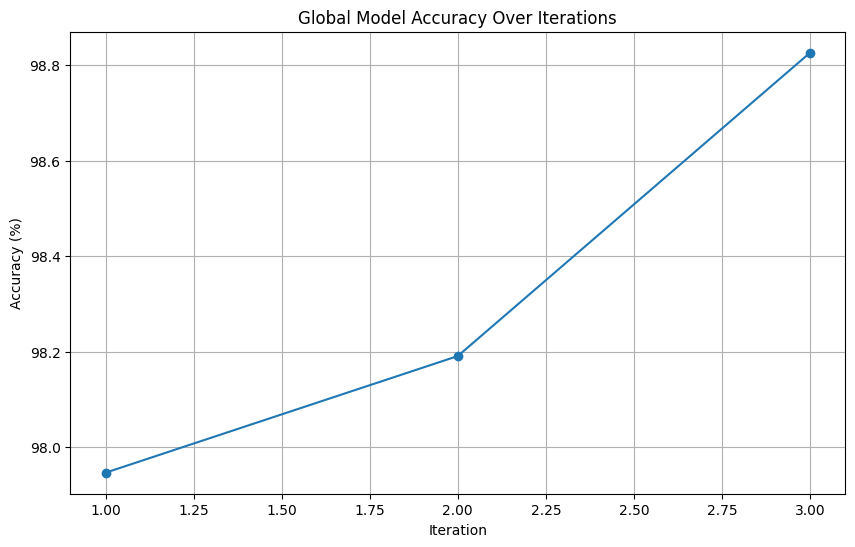

In [76]:
# Plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, ITERATIONS + 1), evaluation_results_global, marker='o')
plt.title('Global Model Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.savefig("img/global_model_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

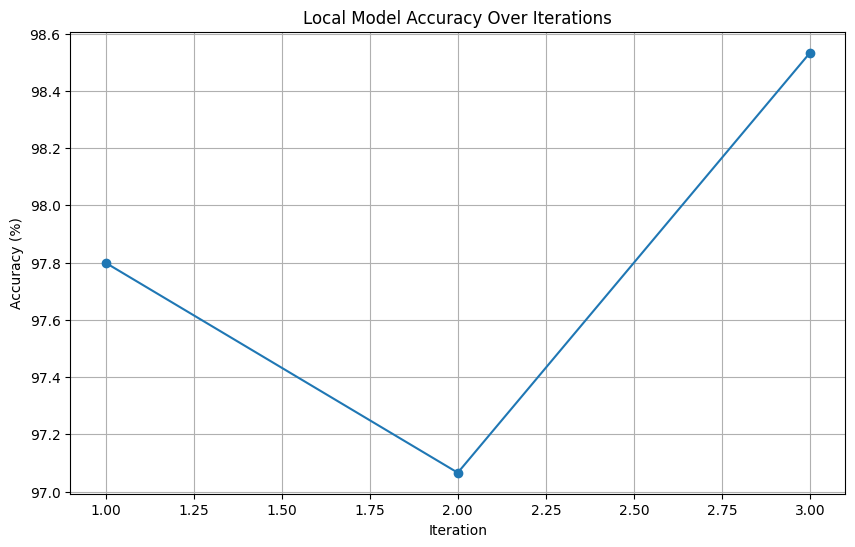

In [77]:
# Plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, ITERATIONS + 1), evaluation_results_local, marker='o')
plt.title('Local Model Accuracy Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.savefig("img/local_model_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [78]:
for i in range(len(client_splits)):
    X_train, X_test, y_train, y_test = client_splits[i]
    accuracy_local = evaluate_model(client_models[i], X_test, y_test)
    print(f"Client {i}: Accuracy = {accuracy_local}")

13/13 [==============================] - 1s 63ms/step
Client 0: Accuracy = 98.53300733496333
13/13 [==============================] - 1s 67ms/step
Client 1: Accuracy = 98.77750611246944
13/13 [==============================] - 1s 67ms/step
Client 2: Accuracy = 99.26650366748166
13/13 [==============================] - 1s 63ms/step
Client 3: Accuracy = 97.79951100244499
13/13 [==============================] - 1s 66ms/step
Client 4: Accuracy = 98.53300733496333
13/13 [==============================] - 1s 63ms/step
Client 5: Accuracy = 98.0440097799511
13/13 [==============================] - 1s 65ms/step
Client 6: Accuracy = 99.02200488997555
13/13 [==============================] - 1s 65ms/step
Client 7: Accuracy = 99.75550122249389
13/13 [==============================] - 1s 68ms/step
Client 8: Accuracy = 99.26650366748166
13/13 [==============================] - 1s 74ms/step
Client 9: Accuracy = 99.26650366748166


In [79]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np

for i in range(len(client_splits)):
    X_train, X_test, y_train, y_test = client_splits[i]
    
    # Get model predictions (probabilities or logits)
    y_pred = client_models[i].predict(X_test)  # Shape: (num_samples, num_classes)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    print(f"Client {i}: Confusion Matrix:\n{cm}\n")

13/13 [==============================] - 1s 81ms/step
Client 0: Confusion Matrix:
[[290   2]
 [  4 113]]

13/13 [==============================] - 1s 75ms/step
Client 1: Confusion Matrix:
[[289   3]
 [  2 115]]

13/13 [==============================] - 1s 83ms/step
Client 2: Confusion Matrix:
[[291   1]
 [  2 115]]

13/13 [==============================] - 1s 69ms/step
Client 3: Confusion Matrix:
[[285   7]
 [  2 115]]

13/13 [==============================] - 1s 70ms/step
Client 4: Confusion Matrix:
[[290   2]
 [  4 113]]

13/13 [==============================] - 1s 75ms/step
Client 5: Confusion Matrix:
[[290   2]
 [  6 111]]

13/13 [==============================] - 1s 80ms/step
Client 6: Confusion Matrix:
[[290   2]
 [  2 115]]

13/13 [==============================] - 1s 72ms/step
Client 7: Confusion Matrix:
[[291   1]
 [  0 117]]

13/13 [==============================] - 1s 76ms/step
Client 8: Confusion Matrix:
[[292   0]
 [  3 114]]

13/13 [==============================] - 1s 73

In [80]:
for i in range(len(client_splits)):
    X_train, X_test, y_train, y_test = client_splits[i]
    accuracy_local = evaluate_model(global_model, X_test, y_test)
    print(f"Client {i}: Accuracy = {accuracy_local}")

13/13 [==============================] - 1s 75ms/step
Client 0: Accuracy = 98.53300733496333
13/13 [==============================] - 1s 72ms/step
Client 1: Accuracy = 98.77750611246944
13/13 [==============================] - 1s 74ms/step
Client 2: Accuracy = 99.26650366748166
13/13 [==============================] - 1s 72ms/step
Client 3: Accuracy = 97.79951100244499
13/13 [==============================] - 1s 72ms/step
Client 4: Accuracy = 98.53300733496333
13/13 [==============================] - 1s 72ms/step
Client 5: Accuracy = 98.0440097799511
13/13 [==============================] - 1s 74ms/step
Client 6: Accuracy = 99.02200488997555
13/13 [==============================] - 1s 73ms/step
Client 7: Accuracy = 99.75550122249389
13/13 [==============================] - 1s 67ms/step
Client 8: Accuracy = 99.26650366748166
13/13 [==============================] - 1s 81ms/step
Client 9: Accuracy = 99.26650366748166
